# JupySQL DuckDB


## Resources

- [JupySQL](https://jupysql.ploomber.io/en/latest/quick-start.html)

- [DuckDB](https://duckdb.org/docs/archive/0.8.1/guides/python/jupyter)


## Setup


In [1]:
# %pip install jupysql duckdb-engine duckdb jupysql-plugin pyarrow --quiet

In [2]:
import duckdb
import pandas as pd

# Enable create sql cells
%load_ext sql

In [3]:
%config SqlMagic.autopandas=True
%config SqlMagic.feedback=False
%config SqlMagic.displaycon=False
%config SqlMagic.named_parameters=True

In [4]:
conn = duckdb.connect(database=":memory:", read_only=False)

In [5]:
%sql conn

## Querying


In [6]:
%sql SELECT 'Off and flying!' as duckdb_column

,duckdb_column
0,Off and flying!


In [7]:
%%sql
SELECT
    schema_name,
    function_name,
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5


,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,shobj_description
2,pg_catalog,shobj_description
3,pg_catalog,pg_typeof
4,pg_catalog,pg_typeof


In [8]:
%sql some_df << SELECT 'Off and flying!' as duckdb_column

In [9]:
some_df.head()

,duckdb_column
0,Off and flying!


In [10]:
input_df = pd.DataFrame.from_dict(
    {"i": [1, 2, 3], "j": ["one", "two", "three"]}
)

In [11]:
result = %sql SELECT sum(i) as total_i FROM input_df
result
result.head()

,total_i
0,6.0


In [12]:
%%sql
INSTALL httpfs;
LOAD httpfs;

,Success


In [13]:
%%sql --save short_trips --no-execute
SELECT *
FROM "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
WHERE trip_distance < 6.3

Skipping execution...

In [14]:
%sql SELECT * FROM short_trips LIMIT 5

Generating CTE with stored snippets: 'short_trips'

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN
3,1,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.60,1.0,N,224,68,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,NaN
4,1,2021-01-01 00:00:28,2021-01-01 00:17:28,1.0,4.10,1.0,N,95,157,2,16.0,0.5,0.5,0.00,0.0,0.3,17.30,0.0,NaN


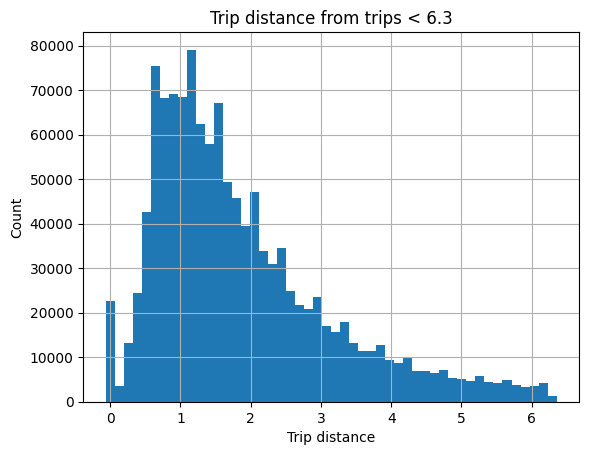

In [15]:
# https://jupysql.ploomber.io/en/latest/plot.html
ax = %sqlplot histogram --table short_trips --column trip_distance --bins 50
ax.grid()
ax.set_title("Trip distance from trips < 6.3")
_ = ax.set_xlabel("Trip distance")

Removing NULLs, if there exists any from payment_type

<Axes: title={'center': 'short_trips'}, xlabel='payment_type', ylabel='Count'>

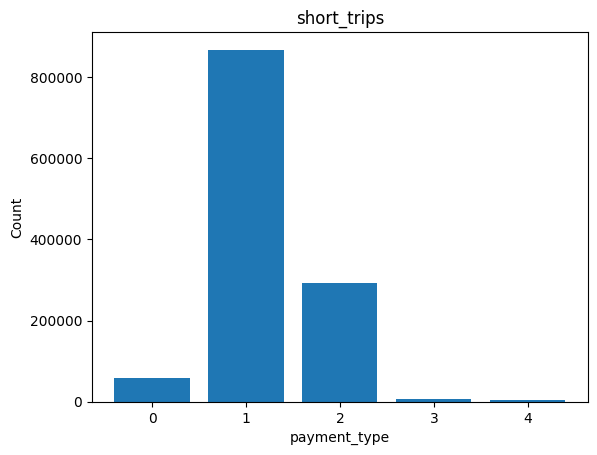

In [16]:
%sqlplot bar --table short_trips --column payment_type

Removing NULLs, if there exists any from payment_type

<Axes: title={'center': 'short_trips'}>

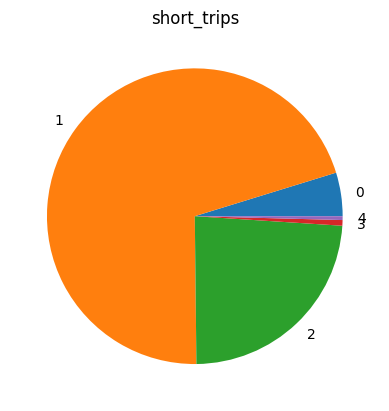

In [17]:
%sqlplot pie --table short_trips --column payment_type

## Nested Json column


In [18]:
%%sql
CREATE OR REPLACE TABLE people(
    id INTEGER,
    name VARCHAR,
    age INTEGER,
    addresses JSON[]
);

INSERT INTO people VALUES
(1, 'John', 30, '[{"street":"123 Main St","city":"New York","state":"NY"},{"street":"456 Elm St","city":"Los Angeles","state":"CA"}]'),
(2, 'Alice', 25, '[{"street":"789 Oak St","city":"Chicago","state":"IL"}]'),
(3, 'Bob', 35, '[{"street":"101 Pine St","city":"San Francisco","state":"CA"},{"street":"202 Cedar St","city":"Seattle","state":"WA"}]');


,Count
0,3


In [19]:
%sql SELECT * FROM people

,id,name,age,addresses
0,1,John,30,"[{""street"":""123 Main St"",""city"":""New York"",""st..."
1,2,Alice,25,"[{""street"":""789 Oak St"",""city"":""Chicago"",""stat..."
2,3,Bob,35,"[{""street"":""101 Pine St"",""city"":""San Francisco..."


In [20]:
%%sql
SELECT
    id,
    name,
    age,
    json_extract(address.addresses::JSON, '$.street') AS street,
    json_extract(address.addresses::JSON, '$.city') AS city,
    json_extract(address.addresses::JSON, '$.state') AS state,

    address.addresses::JSON->>'$.street' AS street,
    address.addresses::JSON->>'$.city' AS city,
    address.addresses::JSON->>'$.state' AS state

FROM people,
    UNNEST(addresses) AS address;

,id,name,age,street,city,state,street_2,city_2,state_2
0,1,John,30,"""456 Elm St""","""Los Angeles""","""CA""",456 Elm St,Los Angeles,CA
1,2,Alice,25,"""789 Oak St""","""Chicago""","""IL""",789 Oak St,Chicago,IL
2,3,Bob,35,"""202 Cedar St""","""Seattle""","""WA""",202 Cedar St,Seattle,WA
3,1,John,30,"""123 Main St""","""New York""","""NY""",123 Main St,New York,NY
4,3,Bob,35,"""101 Pine St""","""San Francisco""","""CA""",101 Pine St,San Francisco,CA


## Subquery


In [21]:
%%sql
CREATE OR REPLACE TABLE students (
    student_id INT PRIMARY KEY,
    student_name VARCHAR(50)
);


CREATE OR REPLACE TABLE grades (
    student_id INT,
    subject VARCHAR(50),
    grade INT
);


INSERT INTO students (student_id, student_name) VALUES
    (1, 'John'),
    (2, 'Alice'),
    (3, 'Bob');

INSERT INTO grades (student_id, subject, grade) VALUES
    (1, 'Math', 90),
    (1, 'Science', 85),
    (2, 'Math', 88),
    (2, 'Science', 92),
    (3, 'Math', 78),
    (3, 'Science', 80);

,Count
0,6


In [22]:
%sqlcmd tables

RuntimeError: %sqlcmd tables is only supported with SQLAlchemy connections, not with DBAPI connections


In [23]:
%sqlcmd profile -t students

,student_id,student_name
count,3,3
unique,3,3
top,nan,John
freq,nan,1
mean,2.0000,nan
std,0.8165,nan
min,1,nan
25%,1.0000,nan
50%,2.0000,nan
75%,3.0000,nan


In [24]:
subject = "Math"

In [25]:
%%sql
SELECT student_name
FROM students
WHERE student_id IN (
    SELECT student_id
    FROM grades
    WHERE subject = '{{subject}}' AND grade > 85
);

,student_name
0,John
1,Alice


In [26]:
%%sql
SELECT AVG(subquery.grade) AS average_math_grade
FROM (
    SELECT grade
    FROM grades
    WHERE subject = 'Math' AND grade > 85
) AS subquery;

,average_math_grade
0,89.0


## Recursive CTE


In [27]:
%%sql
  WITH RECURSIVE factorial_cte(n, factorial) AS (
    SELECT 1, 1   -- Anchor member: initialize the initial values
    UNION ALL
    SELECT n + 1, (n + 1) * factorial
    FROM factorial_cte
    WHERE n < 5   -- Recursive member: perform the recursive calculation until the condition is met
  )
  SELECT factorial
  FROM factorial_cte
  WHERE n = 5;


,factorial
0,120


In [28]:
%%sql
  CREATE OR REPLACE TABLE files (
    file_id INT PRIMARY KEY,
    name VARCHAR(255),
    parent_id INT
  );

  -- Insert sample data into the "files" table
  INSERT INTO files (file_id, name, parent_id) VALUES
    (1, 'root_folder', NULL),
    (2, 'folder1', 1),
    (3, 'folder2', 1),
    (4, 'file1.txt', 2),
    (5, 'file2.txt', 2),
    (6, 'subfolder1', 3),
    (7, 'file3.txt', 6);

  WITH RECURSIVE file_paths AS (
    SELECT file_id, name, parent_id, name as path
    FROM files
    WHERE parent_id IS NULL   -- Anchor member: select the root files
    UNION ALL
    SELECT f.file_id, f.name, f.parent_id, CONCAT(fp.path, '/', f.name)
    FROM files f
    JOIN file_paths fp ON f.parent_id = fp.file_id   -- Recursive member: join with previous level
  )
  SELECT file_id, path
  FROM file_paths;

,file_id,path
0,1,root_folder
1,2,root_folder/folder1
2,3,root_folder/folder2
3,4,root_folder/folder1/file1.txt
4,5,root_folder/folder1/file2.txt
5,6,root_folder/folder2/subfolder1
6,7,root_folder/folder2/subfolder1/file3.txt
